In [ ]:
%load_ext autoreload
%autoreload 2

# EarthPulse Integrations

In this notebook we are going to see an example of how `Pytorch EO` integrates with the rest of [EarthPulse](https://earthpulse.ai/)'s ecosystem: 

- SCAN: our Satellite Collaborative ANnotation Tool, allows us to create, manage and annotate datasets.
- Model Universe: our models repository.

> ⚠ The tools and integrations are under heavy development, so except bugs and breaking changes until we hit an stable version.

## SCAN

SCAN is our tool to create, manage and annotate data. Through a web interface, we explore and download imagery and annotate it with drawing tools. Additionally, we can leverage already trained models to suggest labels instead of having to make them from scratch for every image (AI-assisted labelling).

In [18]:
from pytorch_eo.datasets import SCANDataset
from pytorch_eo.utils.sensors import S2

ds = SCANDataset("eurosat", download=True, batch_size=25, verbose=True, bands=S2.RGB) 

ds.setup()

found info.json
downloading data


100%|██████████| 50/50 [00:00<00:00, 103.69it/s]

training samples 30
validation samples 10
test samples 10


In [19]:
ds.info

{'id': 'eurosat',
 'tasks': ['segmentation'],
 'labels': ['crops', 'vegetation', 'urban', 'water'],
 'num_samples': 50,
 'images': [{'sensor': 'S2L2A', 'id': '3gY0i5rZpDWDnM3ubF98'},
  {'sensor': 'S2L2A', 'id': '4t4KVzUVBXDjhcVeuyZ5'},
  {'sensor': 'S2L2A', 'id': '5HhPjOXKrDEplxlE8Q1E'},
  {'sensor': 'S2L2A', 'id': '5KTwfVNYmJKPBUApkaAG'},
  {'sensor': 'S2L2A', 'id': '5OwgUv8k3uErLh6uGqxu'},
  {'sensor': 'S2L2A', 'id': '5UoqQO4noHqp3qPYDYqU'},
  {'sensor': 'S2L2A', 'id': '7rZWrTw73x45y3pvceHv'},
  {'sensor': 'S2L2A', 'id': '9NqAtzb33aEbRT7gWYE9'},
  {'sensor': 'S2L2A', 'id': '9owKtICrbccQ4LG0a17F'},
  {'sensor': 'S2L2A', 'id': 'A6wo7pYOIQN75K8zoJ2b'},
  {'sensor': 'S2L2A', 'id': 'C6fWby83AQp2aA53AH2l'},
  {'sensor': 'S2L2A', 'id': 'CgOHZuOhG3Ab8LjdMhIU'},
  {'sensor': 'S2L2A', 'id': 'Deb7z96dZHynLGjhcqS5'},
  {'sensor': 'S2L2A', 'id': 'FjUNMoRDW8D0z4wtVOXj'},
  {'sensor': 'S2L2A', 'id': 'HcEbD029S23e9oVBsX2w'},
  {'sensor': 'S2L2A', 'id': 'ILpoWcZa0n0z5prZEccO'},
  {'sensor': 'S2L2A', 

In [20]:
ds.df.sample(10)

,image,mask
3,data/eurosat/5KTwfVNYmJKPBUApkaAG.tif,data/eurosat/5KTwfVNYmJKPBUApkaAG_mask.tif
40,data/eurosat/meddaDF6sktnsAGI5Sl5.tif,data/eurosat/meddaDF6sktnsAGI5Sl5_mask.tif
37,data/eurosat/kR15EG0vEykh3siN4Iky.tif,data/eurosat/kR15EG0vEykh3siN4Iky_mask.tif
30,data/eurosat/ZxmtFQBsmAgaiwSh1Eoy.tif,data/eurosat/ZxmtFQBsmAgaiwSh1Eoy_mask.tif
33,data/eurosat/eKCISj9NQwqtvhRV4qUf.tif,data/eurosat/eKCISj9NQwqtvhRV4qUf_mask.tif
25,data/eurosat/U5vEUzBgvWkO1APE7peL.tif,data/eurosat/U5vEUzBgvWkO1APE7peL_mask.tif
23,data/eurosat/RKSjoniAXXqumbJ0ibOC.tif,data/eurosat/RKSjoniAXXqumbJ0ibOC_mask.tif
8,data/eurosat/9owKtICrbccQ4LG0a17F.tif,data/eurosat/9owKtICrbccQ4LG0a17F_mask.tif
18,data/eurosat/LAw7SxZXSosTAP3zLC0l.tif,data/eurosat/LAw7SxZXSosTAP3zLC0l_mask.tif
36,data/eurosat/joq7PI0gIsYxzdwQxAUj.tif,data/eurosat/joq7PI0gIsYxzdwQxAUj_mask.tif


The original version of `EuroSAT` contains 27k S2 images for the task of image classification, each image has one label assigned to it. From this dataset, we built a new version of `EuroSAT` for testing purposes with 50 S2 images extracted randomly from the original dataset and labeled with polygons that can be used for a segmentation task with new labels.


In [ ]:
ds.classes

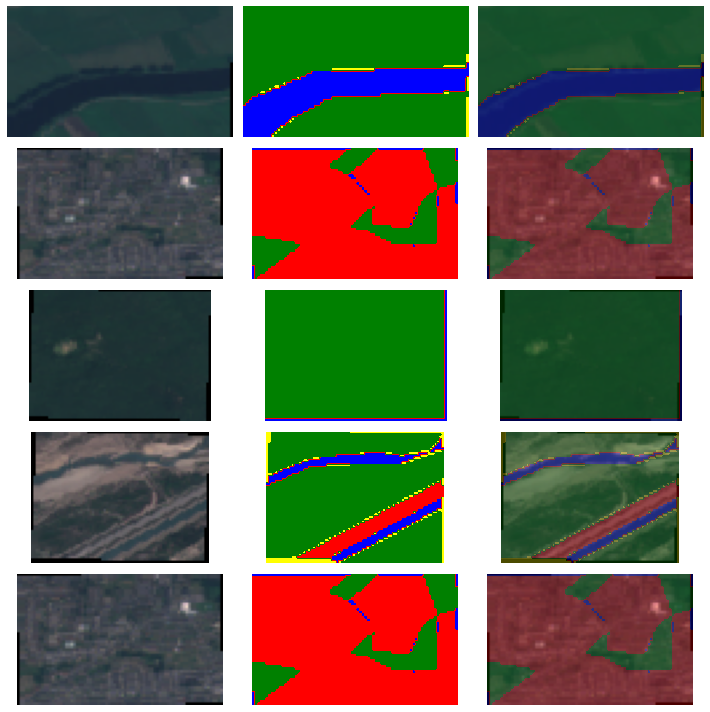

In [21]:
import matplotlib.pyplot as plt
import matplotlib
import torch 
import numpy as np
from pytorch_eo.utils.image import to_uint8
import random

colors = ['yellow', 'green', 'red', 'blue']
cmap = matplotlib.colors.ListedColormap(colors)
boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)

samples = 5
fig = plt.figure(figsize=(10, samples*2))
th = 4000
for i in range(samples):
    sample = ds.train_ds[random.randint(0, len(ds.train_ds)-1)]
    img, mask = sample['image'], sample['mask']
    img = to_uint8(img, 0, th)
    ax = plt.subplot(samples, 3, 3*i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax = plt.subplot(samples, 3, 3*i + 2)
    mask = np.argmax(mask, axis=-1)
    ax.imshow(mask, cmap=cmap, norm=norm)
    ax.axis('off')
    ax = plt.subplot(samples, 3, 3*i + 3)
    ax.imshow(img)
    ax.imshow(mask, cmap=cmap, norm=norm, alpha=0.3)
    #ax.imshow(mask)
    ax.axis('off')
plt.tight_layout()
plt.show()

Now we can train a model for our task.

In [22]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import segmentation_models_pytorch as smp
from einops import rearrange
import torch

class Model(torch.nn.Module):

	def __init__(self, in_chans, num_classes, max_value=4000):
		super().__init__()
		self.model = smp.Unet(
			encoder_name='resnet18',
			encoder_weights='imagenet',
			in_channels=in_chans,
			classes=num_classes,
		)
		self.max_value = max_value
		self.sigmoid = torch.nn.Sigmoid()

	def forward(self, x):
		x = rearrange(x, 'b h w c -> b c h w')
		x = x.float() / self.max_value
		x = x.clip(0., 1.)
		y = self.model(x)
		return rearrange(y, 'b c h w -> b h w c')

In [23]:
from pytorch_eo.tasks.segmentation import ImageSegmentation
import albumentations as A

trans = A.Compose([
	A.Resize(64,64)
])

ds = SCANDataset("eurosat", batch_size=32, val_size=0., test_size=0., train_trans=trans, bands=S2.RGB) 

model = Model(in_chans=3, num_classes=4)

task = ImageSegmentation(model)


In [25]:
import pytorch_lightning as pl 

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=100,
	overfit_batches=2
)

trainer.fit(task, ds)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 14.3 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
14.3 M    T

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [26]:
def viz_preds(model):
    batch = next(iter(ds.train_dataloader(batch_size=5)))
    imgs, masks = batch['image'], batch['mask']

    model.eval()
    with torch.no_grad():
        preds = model(imgs)
    preds = torch.argmax(preds, -1)

    fig = plt.figure(figsize=(10, len(imgs)*4))
    for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):    
        img = to_uint8(img, 0, th)
        ax = plt.subplot(len(imgs), 3, 3*i + 1)
        ax.imshow(img) 
        ax.axis('off')
        ax = plt.subplot(len(imgs), 3, 3*i + 2)
        mask = torch.argmax(mask, axis=-1)
        ax.imshow(mask, cmap=cmap, norm=norm)
        ax.axis('off')
        ax = plt.subplot(len(imgs), 3, 3*i + 3)
        ax.imshow(pred, cmap=cmap, norm=norm)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

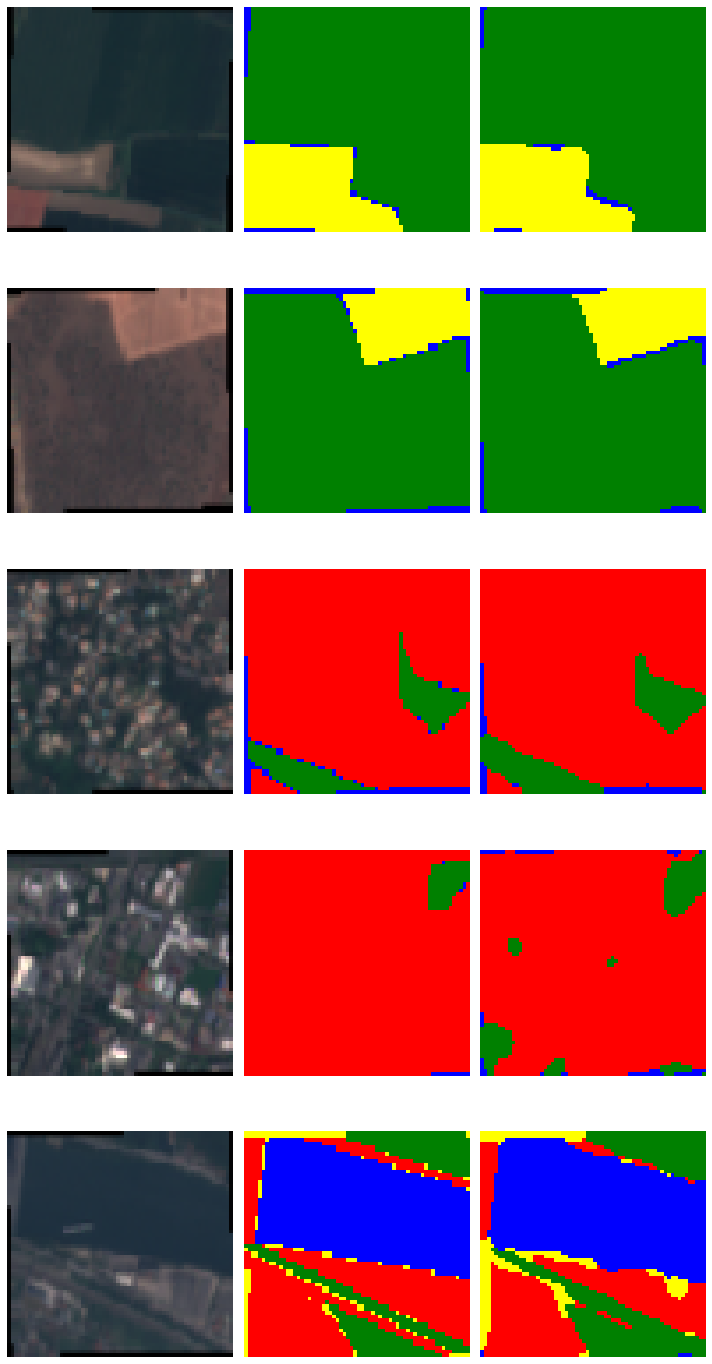

In [27]:
viz_preds(model)

## Models Universe

Once the model is trained, we can upload it to our `Models Universe`. From there, it will be available for inference.

In [28]:
exported_model = torch.nn.Sequential(
	model.cpu(),
	torch.nn.Sigmoid()
)

traced_model = torch.jit.trace(exported_model, torch.randn(5, 64, 64, 3))

traced_model.save('my_model.pth')

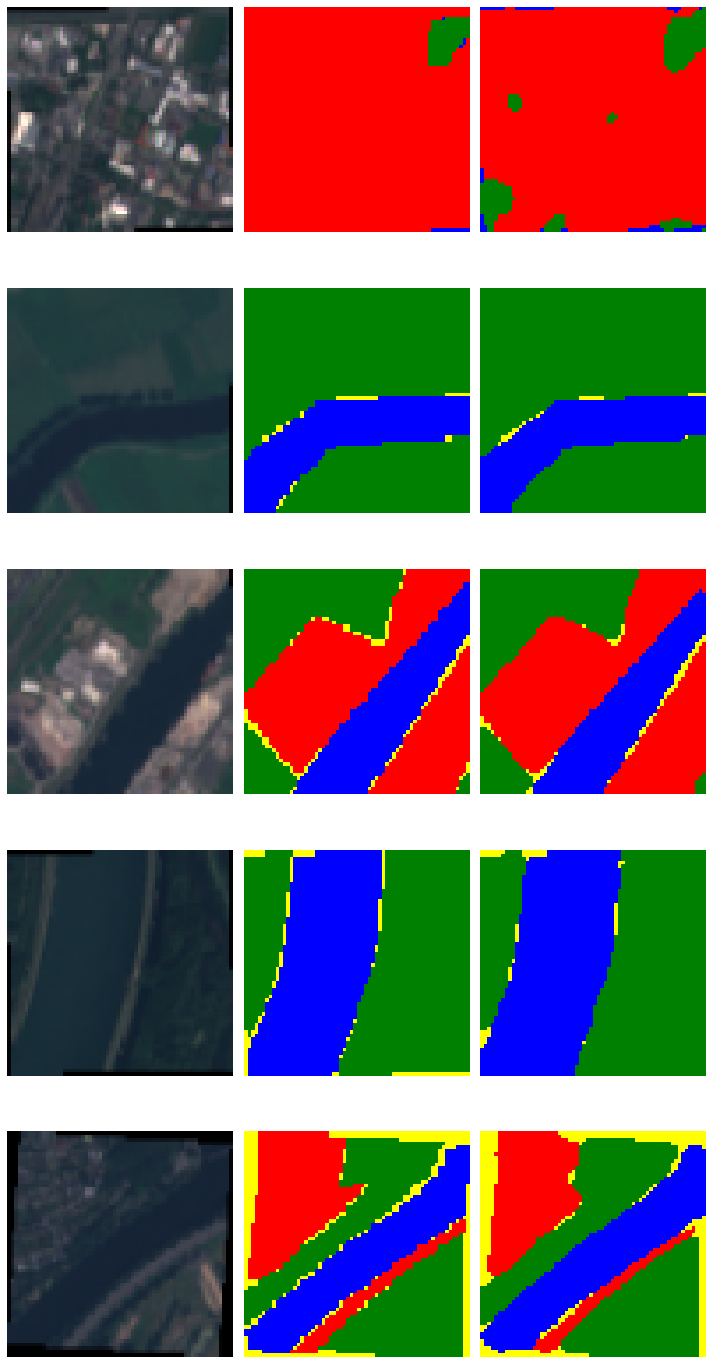

In [31]:
my_model = torch.jit.load('my_model.pth')

viz_preds(my_model)

In [33]:
from pytorch_eo.utils import models_universe

models_universe.upload('my_model.pth', 'eurosat_demo.pth')

{'message': 'successful upload'}

model not found, downloading ... done


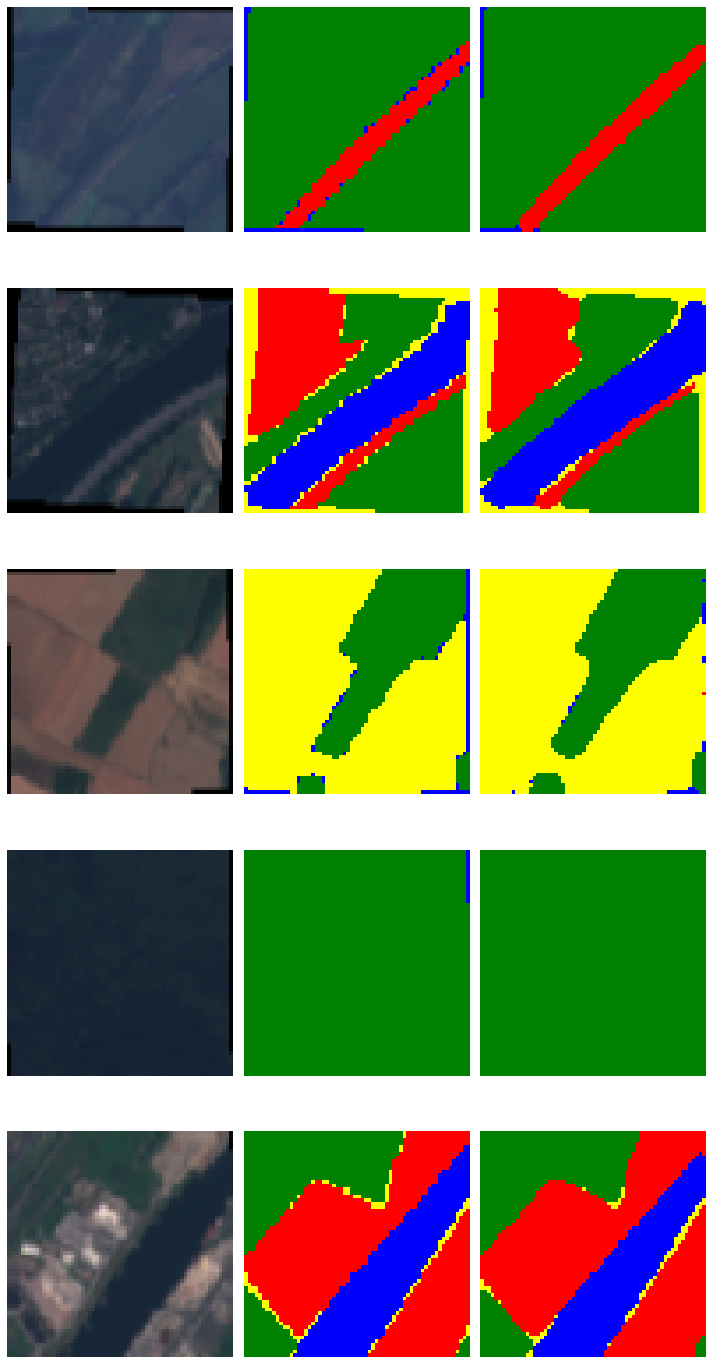

In [34]:
downloaded_model = models_universe.download('eurosat_demo.pth', dest_name='downloaded_model.pth')

viz_preds(downloaded_model)